In [2]:
import json
from hydra import compose, initialize
from pathlib import Path
from collections import defaultdict
from itertools import chain
import pandas as pd
import numpy as np
from rdkit import Chem
from IPython.display import SVG
import matplotlib.pyplot as plt
from ergochemics.draw import draw_molecule
from ergochemics.similarity import molecule_rcmcs
from ergochemics.mapping import extract_operator_patts
from cgr.cheminfo import (
    MorganFingerprinter,
    extract_subgraph,
    resolve_bit_collisions,
    is_subgraph_saturated,
    has_subgraph_only_carbons,
)

In [3]:
with initialize(version_base=None, config_path="../configs/filepaths"):
    filepaths = compose(config_name="filepaths")

krs = Path(filepaths.data) / "raw" / "sprhea_240310_v3_mapped_no_subunits.json"
with open(krs, 'r') as f:
    krs = json.load(f)

decarb = {k: v for k,v  in krs.items() if v['min_rule'] == 'rule0024'}

with open(Path(filepaths.raw_data) / 'decarbs.json', 'w') as f:
    json.dump(decarb, f)

print(len(decarb))

86


In [ ]:
max_hops = 3
vec_len = 2**12
mfper = MorganFingerprinter(radius=max_hops, length=vec_len, allocate_ao=True)
rc_dist_ub = None

patt = extract_operator_patts('[#6:1]-[#6:2]-[#8:3]>>[#6:1].[#6:2]=[#8:3]')[0][0]

mols = []
rcs = []
rids = []
for rid, rxn in decarb.items():
    rc = rxn['reaction_center'][0]
    smiles = rxn['smarts'].split('>>')[0]
    mol = Chem.MolFromSmiles(smiles)
    mols.append(mol)
    rcs.append(rc)
    rids.append(rid)

res = molecule_rcmcs(mols, rcs, patt) # Find subgraph common to all reactant sets
super_rcs = res['rcmcs_idxs']

data = defaultdict(list)
for rid, mol, rc in zip(rids, mols, super_rcs):
    
    _ = mfper.fingerprint(mol, reaction_center=rc, rc_dist_ub=rc_dist_ub)
    bim = mfper.bit_info_map


    for bit_idx, examples in bim.items():
        for (central_aidx, radius) in examples:
            data['feature_id'].append(bit_idx)
            data['sample_id'].append(rid)
            data['mol'].append(mol)

            sub_idxs, sub_mol, sub_smi = extract_subgraph(mol, central_aidx, radius)

            data['sub_idxs'].append(sub_idxs)
            data['sub_smi'].append(sub_smi)
            data['sub_mol'].append(sub_mol)
            data['saturated'].append(is_subgraph_saturated(mol, rc, sub_idxs))
            data['only_carbon'].append(has_subgraph_only_carbons(mol, rc, sub_idxs))
            data['super_rc'].append(rc)
            # data['contains_rc'].append(subgraph_contains_rc_atoms(rc, sub_idxs))

raw_subgraphs = pd.DataFrame(data)

examples, embeddings = resolve_bit_collisions(raw_subgraphs, vec_len)

embed_mat = np.vstack(embeddings['embedding'])
p1 = embed_mat.sum(axis=0) / embed_mat.shape[0]

# examples['accept'] = ~((examples['saturated'] & examples['only_carbon']) | examples['contains_rc']) # TODO come up with something better
examples['accept'] = ~(examples['saturated'] & examples['only_carbon'])
examples['p1'] = 0.0
for ftid in examples['feature_id'].unique():
    examples.loc[examples['feature_id'] == ftid, 'p1'] = p1[ftid]

features = examples.groupby(by='feature_id').aggregate('first')[['sub_smi', 'saturated', 'only_carbon', 'accept', 'p1']]
examples.set_index('feature_id', inplace=True)
examples.drop(columns=['saturated', 'only_carbon', 'accept', 'p1'], inplace=True)

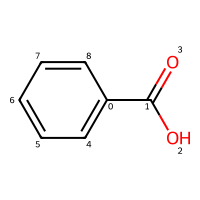

'c.cC(=O)O'

In [21]:
mol = Chem.MolFromSmiles('c1(C(O)=O)ccccc1')
display(SVG(draw_molecule(mol, draw_options={"addAtomIndices": True})))
Chem.MolFragmentToSmiles(mol, atomsToUse=[0, 1, 2, 3, 5])

In [5]:
features.head()

,sub_smi,saturated,only_carbon,accept,p1
feature_id,,,,,
0,OP,True,False,True,0.011628
1,CC(=O)O,False,False,True,0.011628
2,O=P,False,False,True,0.011628
3,n,False,True,True,0.011628
4,CC(N)C(=O)O,False,False,True,0.011628


In [6]:
examples.head()

,sample_id,mol,sub_idxs,sub_smi,sub_mol,super_rc
feature_id,,,,,,
1,121,<rdkit.Chem.rdchem.Mol object at 0x7f0e4ecf1cb0>,"(1, 2, 3, 4)",CC(=O)O,<rdkit.Chem.rdchem.Mol object at 0x7f0e6f973a70>,"(5, 10, 12, 11)"
2,5907,<rdkit.Chem.rdchem.Mol object at 0x7f0e4ecf2650>,"(5, 6)",O=P,<rdkit.Chem.rdchem.Mol object at 0x7f0e6f9c3140>,"(19, 22, 24, 23)"
3,1067,<rdkit.Chem.rdchem.Mol object at 0x7f0e4ecf1d90>,"(10,)",n,<rdkit.Chem.rdchem.Mol object at 0x7f0e6f975e00>,"(3, 1, 2, 0)"
6,5043,<rdkit.Chem.rdchem.Mol object at 0x7f0e4ecf2420>,"(3, 4, 5)",CCC,<rdkit.Chem.rdchem.Mol object at 0x7f0e6f9b59a0>,"(1, 10, 12, 11)"
10,3306,<rdkit.Chem.rdchem.Mol object at 0x7f0e4ecf20a0>,"(9,)",C,<rdkit.Chem.rdchem.Mol object at 0x7f0e6f994510>,"(30, 32, 34, 33)"


Visualize features

Feature id: 2997
Probability: 0.34


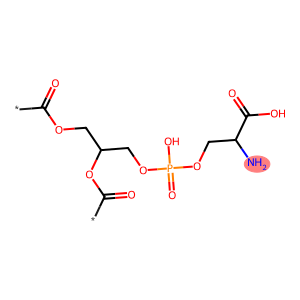

--------------------------------------------------
Feature id: 71
Probability: 0.34


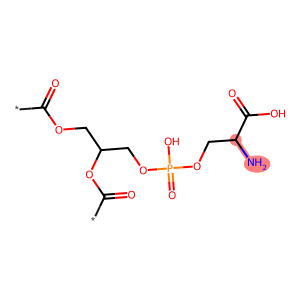

--------------------------------------------------
Feature id: 470
Probability: 0.22


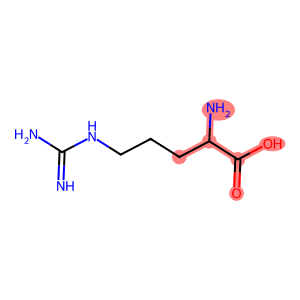

--------------------------------------------------
Feature id: 616
Probability: 0.22


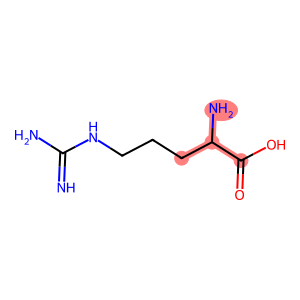

--------------------------------------------------
Feature id: 546
Probability: 0.21


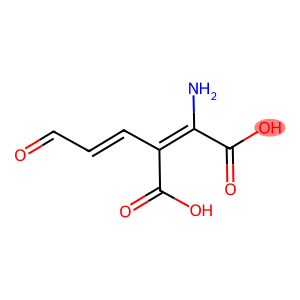

--------------------------------------------------
Feature id: 2659
Probability: 0.21


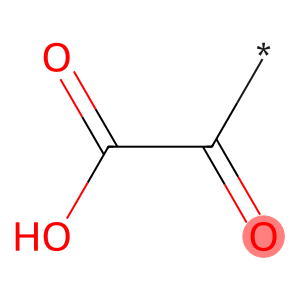

--------------------------------------------------
Feature id: 630
Probability: 0.17


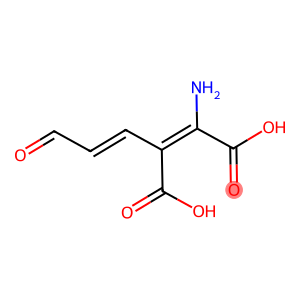

--------------------------------------------------
Feature id: 1873
Probability: 0.17


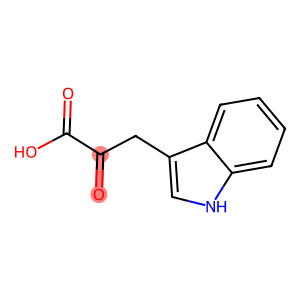

--------------------------------------------------
Feature id: 3738
Probability: 0.15


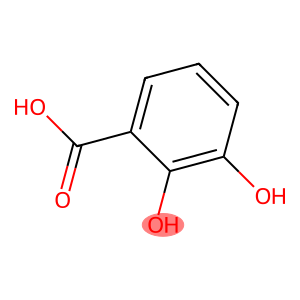

--------------------------------------------------
Feature id: 1401
Probability: 0.15


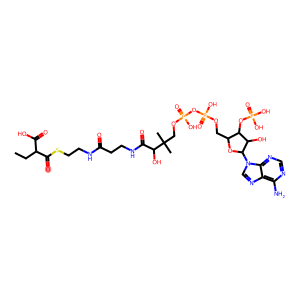

--------------------------------------------------
Feature id: 987
Probability: 0.15


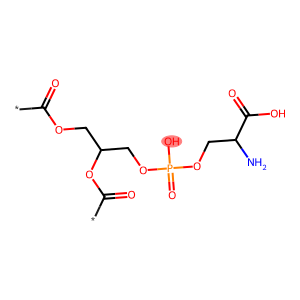

--------------------------------------------------
Feature id: 3472
Probability: 0.13


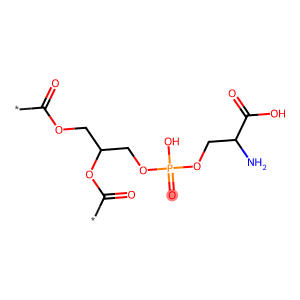

--------------------------------------------------


In [8]:
topk = 10
sort_by = 'p1'
features.sort_values(by=sort_by, inplace=True, ascending=False)
accepted = features[(features['p1'] < 1) & features['accept']]

for i, (ftid, row) in enumerate(accepted.iterrows()):
    mol = examples.loc[[ftid]].iloc[[0]]['mol'].values[0]
    sub_idxs = examples.loc[[ftid]].iloc[[0]]['sub_idxs'].values[0]
    print(f"Feature id: {ftid}")
    print(f"Probability: {row['p1']:.2f}")
    display(SVG(draw_molecule(mol, size=(300, 300), highlight_atoms=tuple(sub_idxs))))
    
    print('-' * 50)
    if i > topk:
        break

In [9]:
leaves = []
levels = 4
p1_init = embed_mat.sum(axis=0) / len(embed_mat)
accepted_ftids_init = accepted.index.to_numpy()
constants = {int(elt) for elt in np.argwhere(p1_init == 1)}

for l in range(levels):
    print(f"Level {l} {'-'*50}")
    if l == 0:
        _most_probable = np.argmax(p1_init[accepted_ftids_init])
        most_probable = int(accepted_ftids_init[_most_probable])
        print(f"Most probable feature: {most_probable}. P={p1_init[most_probable]}")
        leaves.append(( (most_probable, ), (1, ) ))
        leaves.append(( (most_probable, ), (0, ) ))

    else:
        tmp = []
        for questions, answers in leaves:
            answers_arr = np.array(answers).reshape(1, -1)
            subset_mask = (embed_mat[:, questions] == answers_arr).all(axis=1)
            n_remaining = subset_mask.sum()
            print(f"{n_remaining} examples remain after {questions} = {answers}")
            if n_remaining == 0:
                tmp.append((questions, answers))
            else:
                embed_subset = embed_mat[subset_mask]
                accepted_ftids = [elt for elt in accepted_ftids_init if elt not in questions]
                p1 = embed_subset.sum(axis=0) / len(embed_subset)
                _most_probable = np.argmax(p1[accepted_ftids])
                most_probable = int(accepted_ftids[_most_probable])
                print(f"Most probable feature: {most_probable}. P={p1[most_probable]}")
                next_questions = tuple([elt for elt in questions] + [most_probable])
                tmp.append((next_questions, tuple(list(answers) + [1])))
                tmp.append((next_questions, tuple(list(answers) + [0])))
        
        leaves = tmp
    print('\n')

            

Level 0 --------------------------------------------------
Most probable feature: 2997. P=0.3372093023255814


Level 1 --------------------------------------------------
29 examples remain after (2997,) = (1,)
Most probable feature: 71. P=1.0
57 examples remain after (2997,) = (0,)
Most probable feature: 2659. P=0.3157894736842105


Level 2 --------------------------------------------------
29 examples remain after (2997, 71) = (1, 1)
Most probable feature: 470. P=0.6551724137931034
0 examples remain after (2997, 71) = (1, 0)
18 examples remain after (2997, 2659) = (0, 1)
Most probable feature: 1873. P=0.8333333333333334
39 examples remain after (2997, 2659) = (0, 0)
Most probable feature: 546. P=0.3333333333333333


Level 3 --------------------------------------------------
19 examples remain after (2997, 71, 470) = (1, 1, 1)
Most probable feature: 616. P=1.0
10 examples remain after (2997, 71, 470) = (1, 1, 0)
Most probable feature: 788. P=0.9
0 examples remain after (2997, 71) = (1,

/tmp/ipykernel_32308/3439058176.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  constants = {int(elt) for elt in np.argwhere(p1_init == 1)}


In [10]:
leaves

[((2997, 71, 470, 616), (1, 1, 1, 1)),
 ((2997, 71, 470, 616), (1, 1, 1, 0)),
 ((2997, 71, 470, 788), (1, 1, 0, 1)),
 ((2997, 71, 470, 788), (1, 1, 0, 0)),
 ((2997, 71), (1, 0)),
 ((2997, 2659, 1873, 2699), (0, 1, 1, 1)),
 ((2997, 2659, 1873, 2699), (0, 1, 1, 0)),
 ((2997, 2659, 1873, 2800), (0, 1, 0, 1)),
 ((2997, 2659, 1873, 2800), (0, 1, 0, 0)),
 ((2997, 2659, 546, 630), (0, 0, 1, 1)),
 ((2997, 2659, 546, 630), (0, 0, 1, 0)),
 ((2997, 2659, 546, 1401), (0, 0, 0, 1)),
 ((2997, 2659, 546, 1401), (0, 0, 0, 0))]

Feature id: 2997
Probability: 0.34


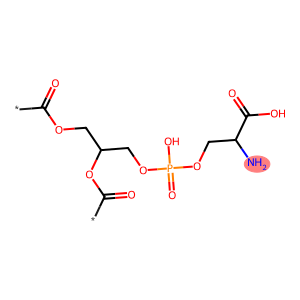

--------------------------------------------------
Feature id: 2659
Probability: 0.21


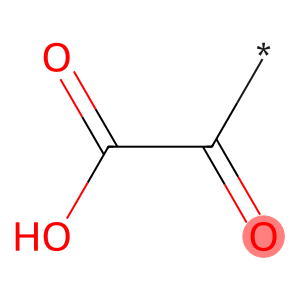

--------------------------------------------------
Feature id: 546
Probability: 0.21


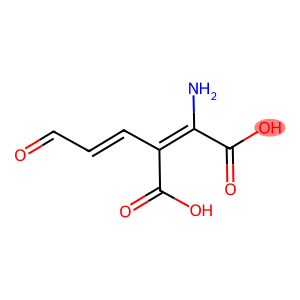

--------------------------------------------------
Feature id: 1401
Probability: 0.15


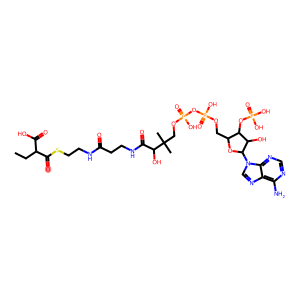

--------------------------------------------------


In [11]:
first_features = []
for questions, answers in leaves:
    try:
        first_idx = answers.index(1)
    except:
        continue
    if questions[first_idx] not in first_features:
        first_features.append(questions[first_idx])

for ftid in first_features:
    mol = examples.loc[[ftid]].iloc[[0]]['mol'].values[0]
    sub_idxs = examples.loc[[ftid]].iloc[[0]]['sub_idxs'].values[0]
    print(f"Feature id: {ftid}")
    print(f"Probability: {accepted.loc[ftid, 'p1']:.2f}")
    display(SVG(draw_molecule(mol, size=(300, 300), highlight_atoms=tuple(sub_idxs))))
    
    print('-' * 50)

PCA

In [12]:
topk = 5
n_samples = len(decarb)

p1_init = embed_mat.sum(axis=0) / len(embed_mat)
accepted_ftids_init = accepted.index.to_numpy()
constants = {int(elt) for elt in np.argwhere(p1_init == 1)}
Sf = np.matmul(embed_mat.T, embed_mat) # ft x ft similarity matrix

fts = []
h_mention = []
while True:
    _most_probable = np.argsort(p1_init[accepted_ftids_init])[::-1]
    most_probable = np.array([int(elt) for elt in accepted_ftids_init[_most_probable]])

    if len(fts) == 0:
        fts.append(most_probable[0])
        h_mention.append(most_probable[1])
    else:
        ortho_mask = Sf[np.array(fts)][:, most_probable].sum(axis=0) == 0
        mp_ortho = most_probable[ortho_mask]
        options = list(zip(mp_ortho[:topk], p1_init[mp_ortho][:topk]))
        options = [(int(elt[0]), float(elt[1])) for elt in options]
        print(f"Options: {options}")

        if len(options) == 0:
            print("Ran out of orthogonal subgraphs")
            break
        
        elif p1_init[mp_ortho[0]] <= (1 / n_samples):
            print("Hit n=1 feature")
            break
        
        fts.append(mp_ortho[0])
        h_mention.append(mp_ortho[1])


print(len(fts))

/tmp/ipykernel_32308/273470416.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  constants = {int(elt) for elt in np.argwhere(p1_init == 1)}


Options: [(2659, 0.20930232558139536), (1873, 0.1744186046511628), (1401, 0.1511627906976744), (454, 0.11627906976744186), (2980, 0.11627906976744186)]
Options: [(1401, 0.1511627906976744), (454, 0.11627906976744186), (2980, 0.11627906976744186), (504, 0.08139534883720931), (3523, 0.06976744186046512)]
Options: [(454, 0.11627906976744186), (2980, 0.11627906976744186), (3523, 0.06976744186046512), (766, 0.05813953488372093), (2036, 0.046511627906976744)]
Options: [(1019, 0.03488372093023256), (3782, 0.03488372093023256), (802, 0.03488372093023256), (593, 0.03488372093023256), (1939, 0.03488372093023256)]
Options: [(3782, 0.03488372093023256), (802, 0.03488372093023256), (593, 0.03488372093023256), (1939, 0.03488372093023256), (2211, 0.03488372093023256)]
Options: [(3566, 0.011627906976744186), (3571, 0.011627906976744186), (63, 0.011627906976744186), (3749, 0.011627906976744186), (3748, 0.011627906976744186)]
Hit n=1 feature
6


In [13]:
remaining_rxns_mask = (embed_mat[:, fts].sum(axis=1)) == 0
remaining_rxns = embeddings.loc[remaining_rxns_mask, 'sample_id'].to_list()
len(remaining_rxns)

10

Feature id: 71
Fraction: 0.3372
Cumulative fraction: 0.3372


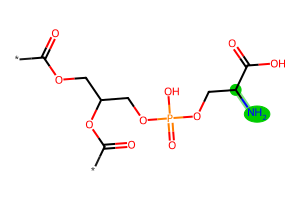

--------------------------------------------------
Feature id: 2659
Fraction: 0.2093
Cumulative fraction: 0.5465


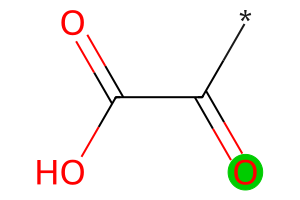

--------------------------------------------------
Feature id: 1401
Fraction: 0.1512
Cumulative fraction: 0.6977


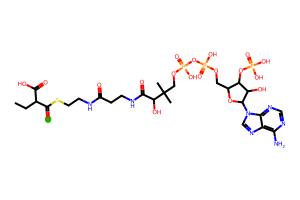

--------------------------------------------------
Feature id: 454
Fraction: 0.1163
Cumulative fraction: 0.8140


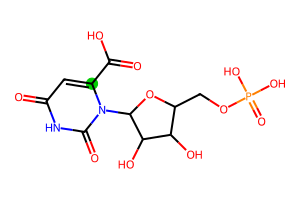

--------------------------------------------------
Feature id: 1019
Fraction: 0.0349
Cumulative fraction: 0.8488


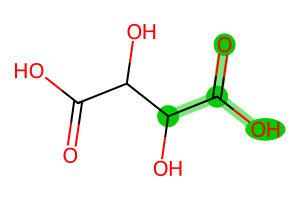

--------------------------------------------------
Feature id: 3782
Fraction: 0.0349
Cumulative fraction: 0.8837


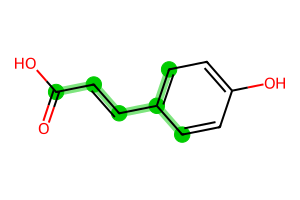

--------------------------------------------------


In [14]:
cum_fraction = 0
n_egs = 1
highlight_rc = False
highlight_color = (0, 0.8, 0, 0.5)
frac_stack = []

for ftid in fts:
    frac = accepted.loc[ftid, 'p1']
    frac_stack.append(frac)
    cum_fraction += frac
    print(f"Feature id: {ftid}")
    print(f"Fraction: {frac:.4f}")
    print(f"Cumulative fraction: {cum_fraction:.4f}")
    for i in range(n_egs):
        if i >= len(examples.loc[[ftid]]):
            break
        
        mol = examples.loc[[ftid]].iloc[[i]]['mol'].values[0]
        sub_idxs = examples.loc[[ftid]].iloc[[i]]['sub_idxs'].values[0]
        super_rc = examples.loc[[ftid]].iloc[[i]]['super_rc'].values[0]

        if highlight_rc:
            display(SVG(draw_molecule(mol, size=(300, 200), highlight_atoms=chain(sub_idxs, super_rc), draw_options={'setHighlightColour':highlight_color})))
        else:
            display(SVG(draw_molecule(mol, size=(300, 200), highlight_atoms=sub_idxs, draw_options={'setHighlightColour':highlight_color})))
    
    print('-' * 50)

frac_stack.append(1 - sum(frac_stack))

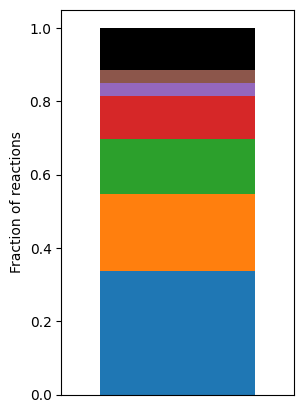

In [15]:
fig, ax = plt.subplots(figsize=(3, 5))
bottom = 0
width = 0.4
x = 0
for i, frac in enumerate(frac_stack):
    if i == len(frac_stack) - 1:
        ax.bar(x=x, height=frac, width=width, bottom=bottom, color='black')
    else:
        ax.bar(x=x, height=frac, width=width, bottom=bottom)
    bottom += frac

ax.set_xlim(-0.3, 0.3)
ax.set_xticks([])
ax.set_ylabel("Fraction of reactions")

plt.show()

Feature id: 2997


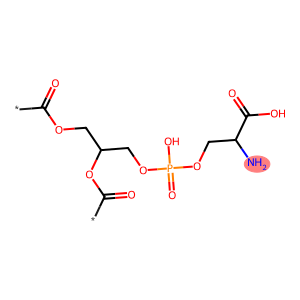

--------------------------------------------------
Feature id: 1873


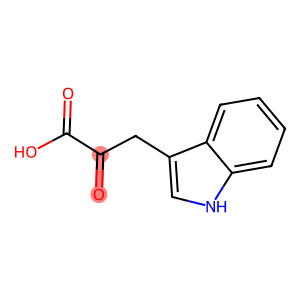

--------------------------------------------------
Feature id: 2980


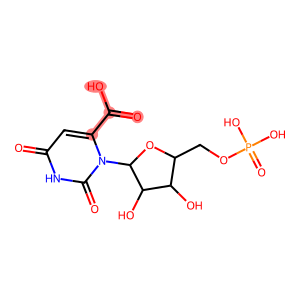

--------------------------------------------------
Feature id: 802


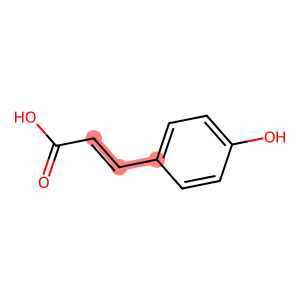

--------------------------------------------------


In [16]:
for ftid in h_mention:
    if ftid in fts:
        continue
    
    mol = examples.loc[[ftid]].iloc[[0]]['mol'].values[0]
    sub_idxs = examples.loc[[ftid]].iloc[[0]]['sub_idxs'].values[0]
    frac = accepted.loc[ftid, 'p1']
    cum_fraction += frac
    print(f"Feature id: {ftid}")
    display(SVG(draw_molecule(mol, size=(300, 300), highlight_atoms=tuple(sub_idxs))))
    
    print('-' * 50)

Sample id: 121


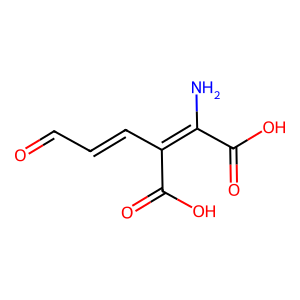

--------------------------------------------------
Sample id: 16361


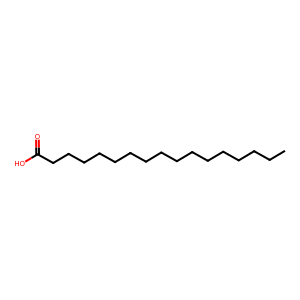

--------------------------------------------------
Sample id: 17237


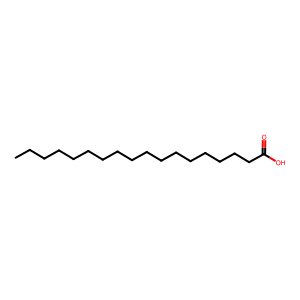

--------------------------------------------------
Sample id: 17305


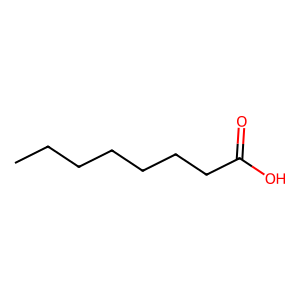

--------------------------------------------------
Sample id: 18112


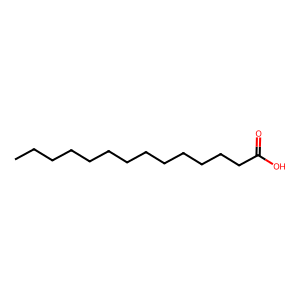

--------------------------------------------------
Sample id: 19342


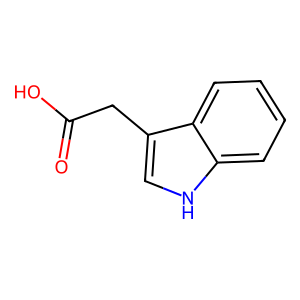

--------------------------------------------------
Sample id: 4235


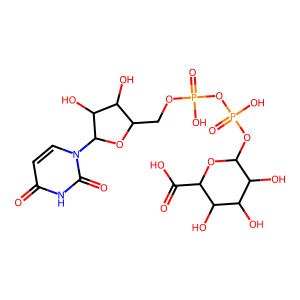

--------------------------------------------------
Sample id: 5907


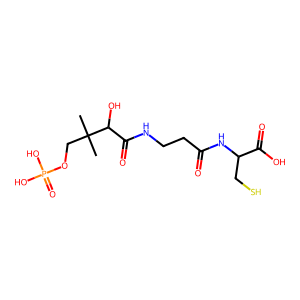

--------------------------------------------------
Sample id: 6613


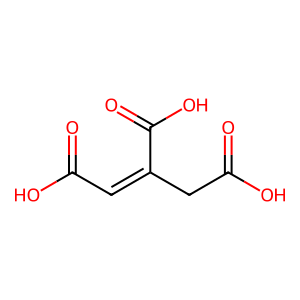

--------------------------------------------------
Sample id: 9599


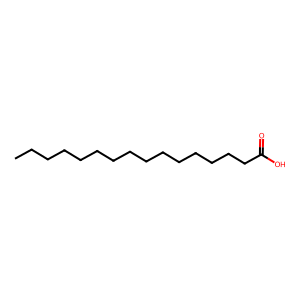

--------------------------------------------------


In [17]:
for sample_id in remaining_rxns:
    
    mol = examples.loc[examples['sample_id'] == sample_id].iloc[[0]]['mol'].values[0]
    # sub_idxs = examples.loc[examples['sample_id'] == sample_id].iloc[[0]]['sub_idxs'].values[0]
    cum_fraction += frac
    print(f"Sample id: {sample_id}")
    display(SVG(draw_molecule(mol, size=(300, 300))))
    
    print('-' * 50)